## Time Series Forecasting - NYC Air Quality

In [376]:
# Import nexessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline
import seaborn as sns
from datetime import datetime
from copy import copy
import warnings 
warnings.filterwarnings("ignore")

In [377]:
# Load Dataset
data = pd.read_csv('/Users/Joyce630/Desktop/Columbia/5420 Anomaly Detection/Assignments/1 - Air Quality/US_AQI.csv')

In [378]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5617325 entries, 0 to 5617324
Data columns (total 15 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   CBSA Code                  int64  
 2   Date                       object 
 3   AQI                        int64  
 4   Category                   object 
 5   Defining Parameter         object 
 6   Number of Sites Reporting  int64  
 7   city_ascii                 object 
 8   state_id                   object 
 9   state_name                 object 
 10  lat                        float64
 11  lng                        float64
 12  population                 float64
 13  density                    float64
 14  timezone                   object 
dtypes: float64(4), int64(4), object(7)
memory usage: 642.9+ MB


In [379]:
#Filter the data for New York and last 10 years
ny_data_2012_2022 = data[(data['city_ascii'] == 'New York') &
                                 (data['Date'] >= '2012-01-01') & 
                                 (data['Date'] <= '2022-05-30')]
ny_data_2012_2022.tail()

Unnamed: 0  CBSA Code        Date  AQI  Category Defining Parameter  \
1634788     1664706      35620  2012-12-27   43      Good              PM2.5   
1634789     1664707      35620  2012-12-28   48      Good              PM2.5   
1634790     1664708      35620  2012-12-29   69  Moderate              PM2.5   
1634791     1664709      35620  2012-12-30   53  Moderate              PM2.5   
1634792     1664710      35620  2012-12-31   57  Moderate              PM2.5   

         Number of Sites Reporting city_ascii state_id state_name      lat  \
1634788                         31   New York       NY   New York  40.6943   
1634789                         30   New York       NY   New York  40.6943   
1634790                         39   New York       NY   New York  40.6943   
1634791                         32   New York       NY   New York  40.6943   
1634792                         33   New York       NY   New York  40.6943   

             lng  population  density          timezone  
1634788 -73.9249  18680025.0  10768.0  America/New_York  
1634789 -73.9249  18680025.0  10768.0  America/New_York  
1634790 -73.9249  18680025.0  10768.0  America/New_York  
1634791 -73.9249  18680025.0  10768.0  America/New_York  
1634792 -73.9249  18680025.0  10768.0  America/New_York

In [380]:
# Sets pathces for different aqi levels
GOOD = plt.Rectangle((-1_000,0), 17_500, 50, fc='green',ec="green", alpha=0.25)
MODERATE = plt.Rectangle((-1_000,50), 17_500, 50, fc='yellow',ec="yellow", alpha=0.25)
UNHEALTHY_FOR_SENSITIVE = plt.Rectangle((-1_000,100), 17_500, 50,
                                                  fc='orange',ec="orange", alpha=0.25)
UNHEALTHY = plt.Rectangle((-1_000,150), 17_500, 50, fc='red',ec="red", alpha=0.25)
VERY_UNHEALTHY = plt.Rectangle((-1_000,200), 17_500, 100, fc='purple',ec="purple", alpha=0.25)
HAZARDOUS = plt.Rectangle((-1_000,300), 17_500, 200, fc='maroon',ec="maroon", alpha=0.25)

In [381]:
# Function to plot aqi given an area
def make_aqi_by_area_plot(df, area, clip_dates=True):
    if clip_dates:
        data = df.unstack().loc[area, :"2022-01-01"]
    else:
        data = df.unstack().loc[area]
        
    data.plot(figsize=(12,5), color='black', alpha=0.75)
    
    
    plt.title(f'{area} Average AQI 2012-2022', {'size': 20, 'weight': 'bold'})

    # adds color patches 
    plt.gca().add_patch(copy(GOOD))
    plt.gca().add_patch(copy(MODERATE))
    plt.gca().add_patch(copy(UNHEALTHY_FOR_SENSITIVE))
    plt.gca().add_patch(copy(UNHEALTHY))
    plt.gca().add_patch(copy(VERY_UNHEALTHY))
    plt.gca().add_patch(copy(HAZARDOUS))

    plt.xlabel('Date')
    plt.ylabel('AQI', {'size': 12, 'weight': 'bold'})
    
    plt.ylim(0, 500)
    
    #sets up legend
    legend_elements = [
        Patch(facecolor='green', edgecolor='black', alpha=0.5, label='Good'),
        Patch(facecolor='yellow', edgecolor='black', alpha=0.5, label='Moderate'),
        Patch(facecolor='orange', edgecolor='black', alpha=0.5, label='Unhealthy for Sensitive Groups'),
        Patch(facecolor='red', edgecolor='black', alpha=0.5, label='Unhealthy'),
        Patch(facecolor='purple', edgecolor='black', alpha=0.5, label='Very Unhealthy'),
        Patch(facecolor='maroon', edgecolor='black', alpha=0.5, label='Hazardous'),
                      ]

    legend = plt.legend(handles=legend_elements)
    legend.set_title("AQI Category", prop = {'size':10, 'weight': 'bold'})

    plt.savefig('Average AQI 2012-2022.png', transparent=True)
    
    #display plot
    plt.show()

## Overview of the NYC Average AQI trend from 2012-2022

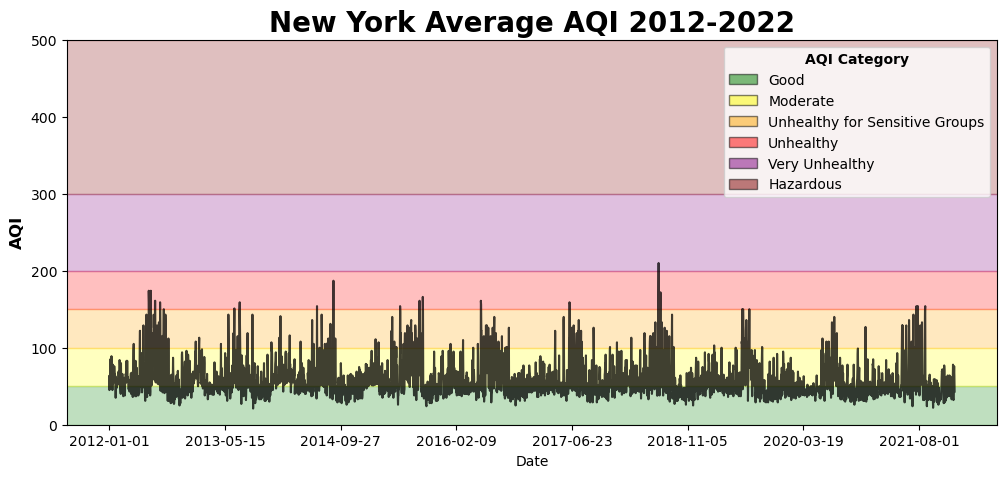

In [382]:
# Makes dataframe of NYC AQI averages
aqi_by_city = ny_data_2012_2022.groupby(['city_ascii', 'Date']).AQI.mean()

# Plots AQI averages for NY
for city in ['New York']:
    make_aqi_by_area_plot(aqi_by_city, city)

In [383]:
ny_data_2012_2022['Date']=pd.to_datetime(ny_data_2012_2022['Date'])
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = ny_data_2012_2022.copy()
    df['date'] = df.index
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(ny_data_2012_2022, label='AQI')

features_and_target = pd.concat([X, y], axis=1)

In [384]:
# See our features and target
features_and_target.head()

dayofweek  quarter  month  year  dayofyear  dayofmonth  AQI
15819          5        1      1  2022          1           1   43
15820          6        1      1  2022          2           2   40
15821          0        1      1  2022          3           3   35
15822          1        1      1  2022          4           4   44
15823          2        1      1  2022          5           5   65

## EDA

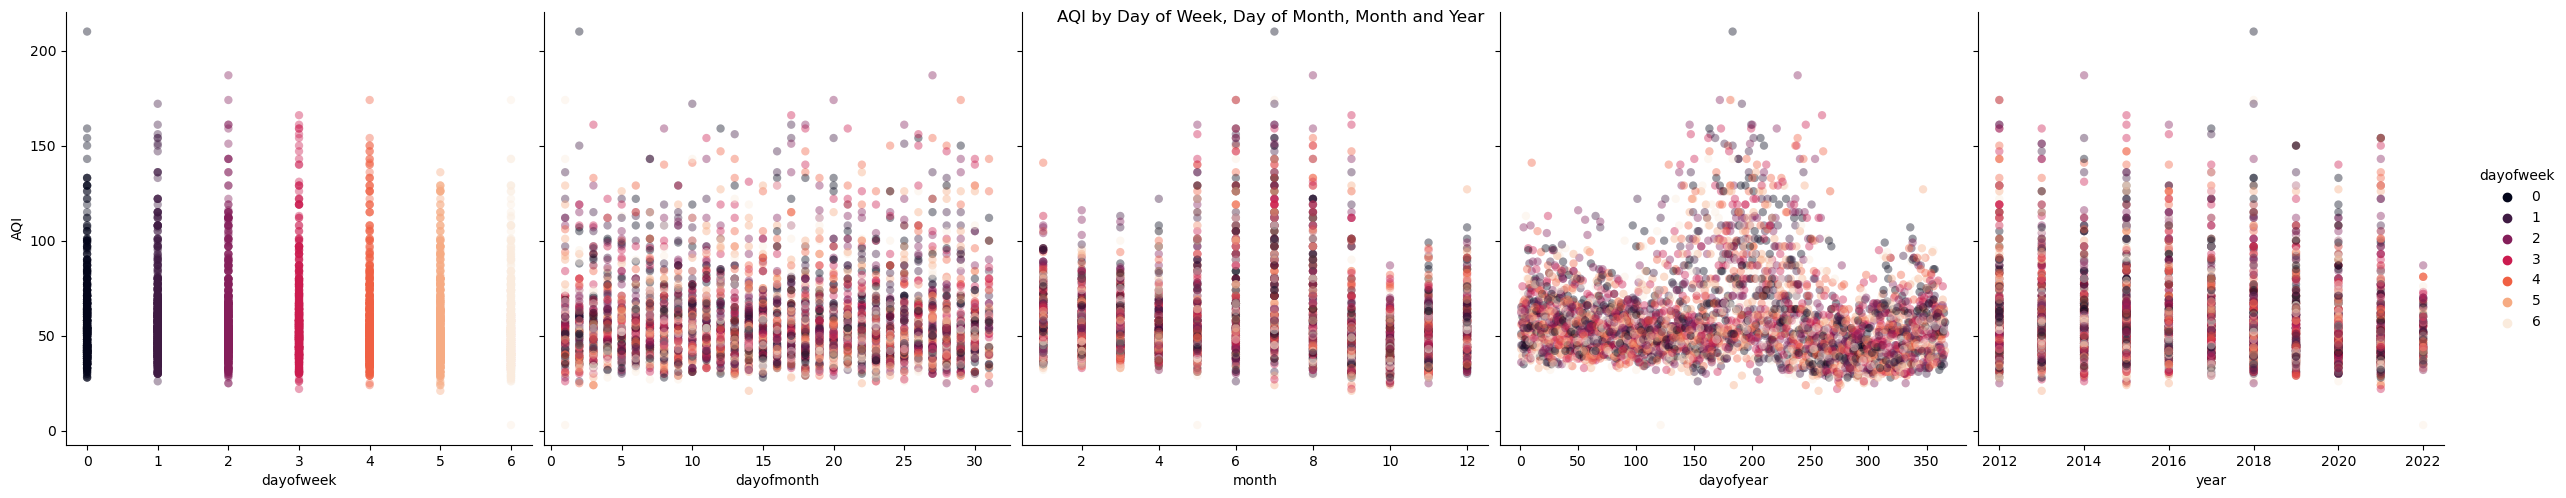

In [385]:

sns.pairplot(features_and_target.dropna(),
             hue='dayofweek',
             x_vars=['dayofweek', 'dayofmonth', 'month','dayofyear',
                     'year'],
             y_vars='AQI',
             height=5,
             plot_kws={'alpha':0.4, 'linewidth':0},
             palette='rocket'
            )

plt.suptitle('AQI by Day of Week, Day of Month, Month and Year')
plt.show()

In [386]:
# Rename columns, convert date to datetime format & set as index
ny = ny_data_2012_2022[['Date', 'AQI']]
ny.columns = ['ds','y']
ny['ds'] = pd.to_datetime(ny['ds'])
ny.set_index('ds', inplace = True)
ny.head()

y
ds            
2022-01-01  43
2022-01-02  40
2022-01-03  35
2022-01-04  44
2022-01-05  65

## Simple Moving Average

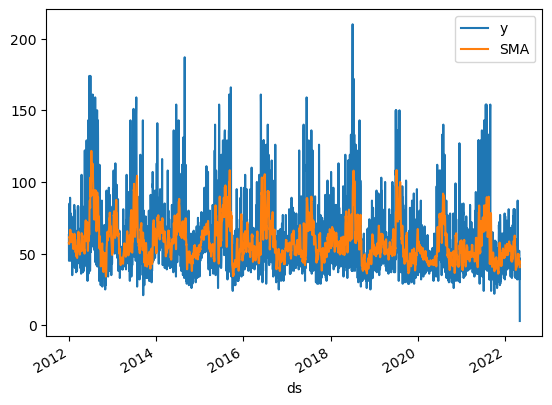

In [387]:
# Compute Simple Moving Average (SMA) and difference between actual and SMA
ny['SMA'] = ny.iloc[:,0].rolling(window=10).mean()
ny['diff'] = ny['y'] - ny['SMA']
ny[['y','SMA']].plot()
plt.savefig('sma.png', transparent=True)

# Display the plot
plt.show()

#### The SMA graph showed the actual observed values of the air quality index over time in blue while the SMA line provided a clearer view of the overall trend, filtering out noise and making it easier to identify significant anomalies.

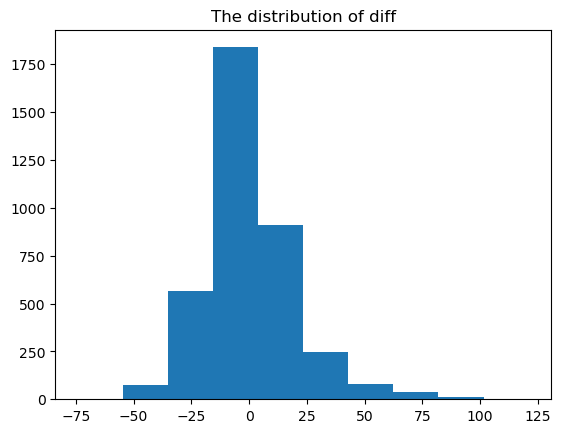

In [388]:
ny['diff'].hist()
plt.grid(False)
plt.title('The distribution of diff')
plt.savefig('diffsma.png', transparent=True)

# Display the plot
plt.show()

#### The above graph showed the majority of data fell within a range of +/- 25 from the SMA

In [389]:
# Define upper and lower bounds for the tolerance band
ny['upper'] = ny['SMA'] + 25
ny['lower'] = ny['SMA'] - 25
ny[10:20]

y   SMA  diff  upper  lower
ds                                      
2022-01-11  57  50.4   6.6   75.4   25.4
2022-01-12  55  51.9   3.1   76.9   26.9
2022-01-13  73  55.7  17.3   80.7   30.7
2022-01-14  56  56.9  -0.9   81.9   31.9
2022-01-15  47  55.1  -8.1   80.1   30.1
2022-01-16  39  53.4 -14.4   78.4   28.4
2022-01-17  39  51.8 -12.8   76.8   26.8
2022-01-18  58  52.4   5.6   77.4   27.4
2022-01-19  51  52.7  -1.7   77.7   27.7
2022-01-20  52  52.7  -0.7   77.7   27.7

<Figure size 640x480 with 0 Axes>

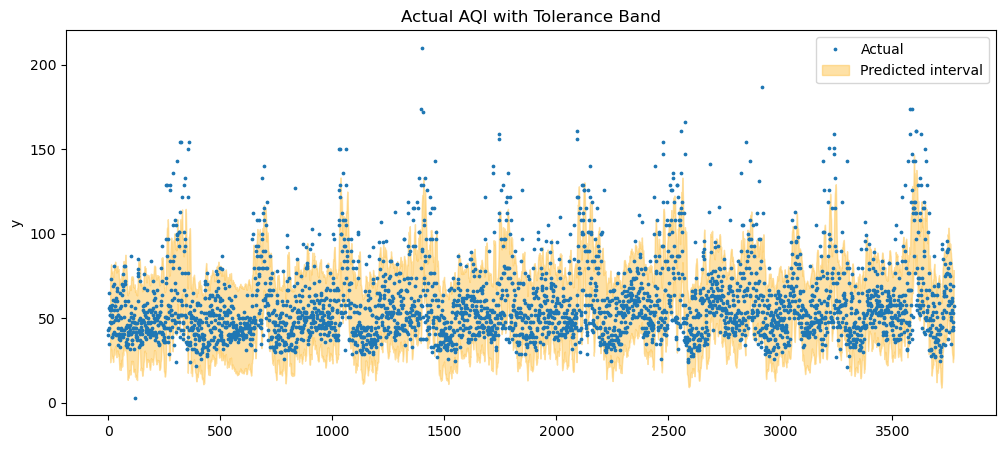

In [390]:
# Reset index for smoother plotting
ny = ny.reset_index(drop='index')

# Function to plot actual AQI values with SMA and tolerance band
def plot_it():
    plt.figure(figsize=(12, 5))
    plt.plot(ny['y'],'o',markersize=1.7, label='Actual')
    plt.fill_between(
        np.arange(ny.shape[0]), ny['lower'], ny['upper'], color='#fec44f', alpha=0.5,
        label='Predicted interval')
    plt.ylabel('y')
    plt.title('Actual AQI with Tolerance Band')
    plt.legend()
    plt.show()
plt.savefig('sample_plot_transparent.jpg', transparent=True)
plot_it()

#### Defining the upper and lower bounds for the tolerance band help define a range of expected variation around the SMA since data often fluctuates, and not every deviation from the SMA is an anomaly. The blue dots that fall outside of the predicted interval could prompt further investigation to understand the case of these deviations.

## Exponential Smoothing

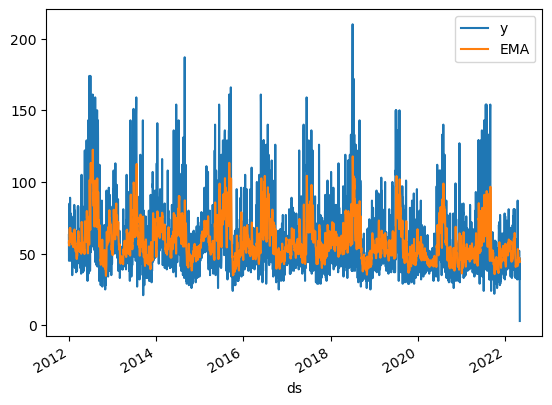

In [391]:
ny = ny_data_2012_2022[['Date', 'AQI']]
ny.columns = ['ds','y']
ny['ds'] = pd.to_datetime(ny['ds'])
ny.set_index('ds', inplace = True)

# Perform Exponential Moving Average (EMA) smoothing and difference between actual and EMA
EMAfit = SimpleExpSmoothing(ny['y']).fit(smoothing_level=0.2,optimized=False)
EMA = EMAfit.forecast(3).rename(r'$\alpha=0.2$')
ny['EMA'] = EMAfit.predict(start = 0)
ny['diff'] = ny['y'] - ny['EMA']
ny[['y','EMA']].plot()

plt.savefig('ema.png', transparent=True)

# Display the plot
plt.show()

#### Similar to SMA, Exponential Smoothing gives more weight to recent observations, making it more responsive to changes.

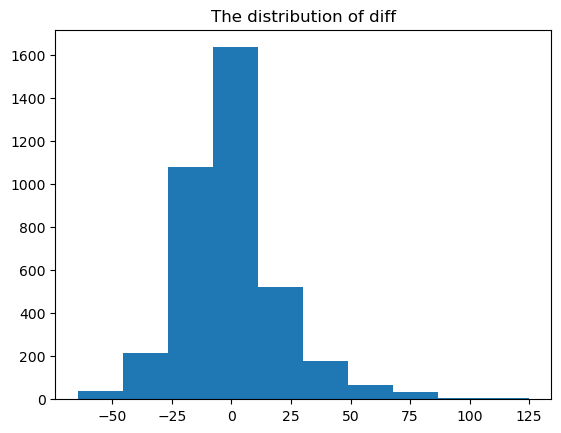

In [392]:
ny['diff'].hist()
plt.grid(False)
plt.title('The distribution of diff')
plt.savefig('diffema.png', transparent=True)

# Display the plot
plt.show()

In [393]:
# Define upper and lower bounds for the tolerance band
ny['upper'] = ny['EMA'] + 25
ny['lower'] = ny['EMA'] - 25
ny[10:20]

y        EMA       diff      upper      lower
ds                                                        
2022-01-11  57  50.103773   6.896227  75.103773  25.103773
2022-01-12  55  51.483019   3.516981  76.483019  26.483019
2022-01-13  73  52.186415  20.813585  77.186415  27.186415
2022-01-14  56  56.349132  -0.349132  81.349132  31.349132
2022-01-15  47  56.279305  -9.279305  81.279305  31.279305
2022-01-16  39  54.423444 -15.423444  79.423444  29.423444
2022-01-17  39  51.338756 -12.338756  76.338756  26.338756
2022-01-18  58  48.871004   9.128996  73.871004  23.871004
2022-01-19  51  50.696804   0.303196  75.696804  25.696804
2022-01-20  52  50.757443   1.242557  75.757443  25.757443

In [394]:
ny = ny.reset_index(drop='index')

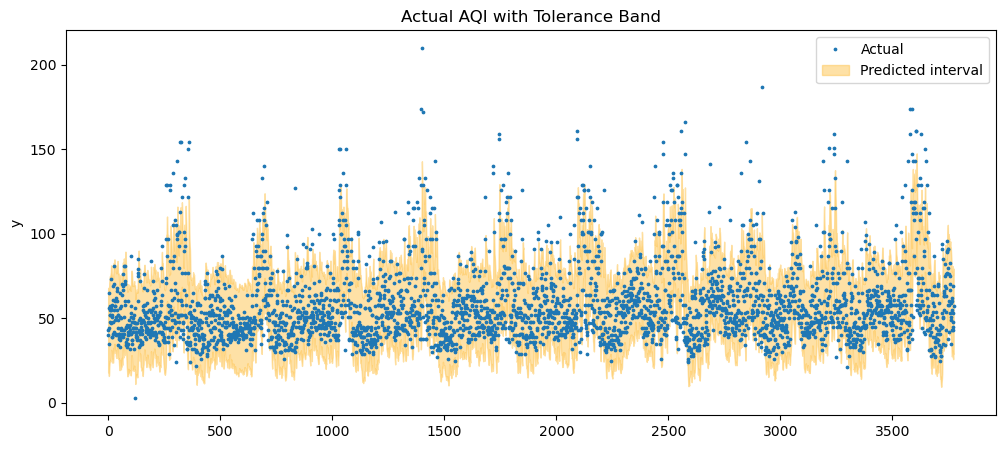

In [395]:
plot_it()

## Seasonal-Trend Decomposition

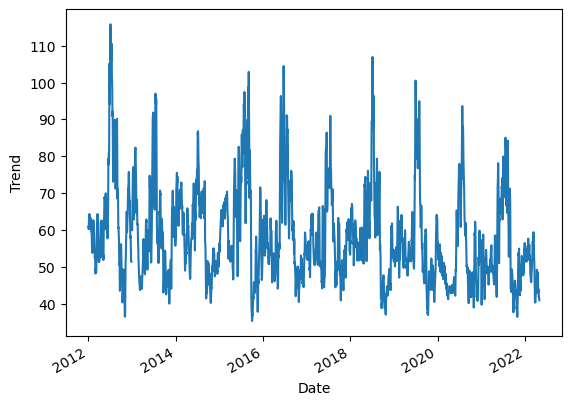

In [396]:
# Perform seasonal decomposition using STL
import statsmodels.api as sm

ny = ny_data_2012_2022[['Date', 'AQI']]
ny = ny.reset_index(drop='index')
ny['Date'] = pd.to_datetime(ny['Date'])
ny.set_index('Date', inplace = True)

# Extract the observed, trend, seasonal, and residual components
result = sm.tsa.seasonal_decompose(ny['AQI'], model='addictive', period = 12)
result.trend.plot()
plt.savefig('trend.png', transparent=True)
plt.ylabel('Trend')
# Display the plot
plt.show()

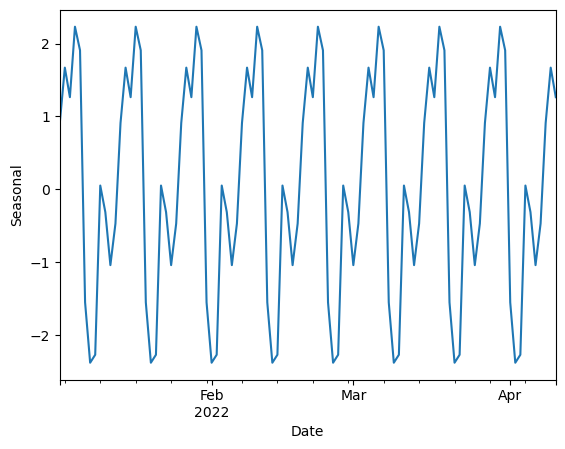

In [397]:
result.seasonal[1:100].plot()
plt.savefig('seasonal.png', transparent=True)
plt.ylabel('Seasonal')
# Display the plot
plt.show()

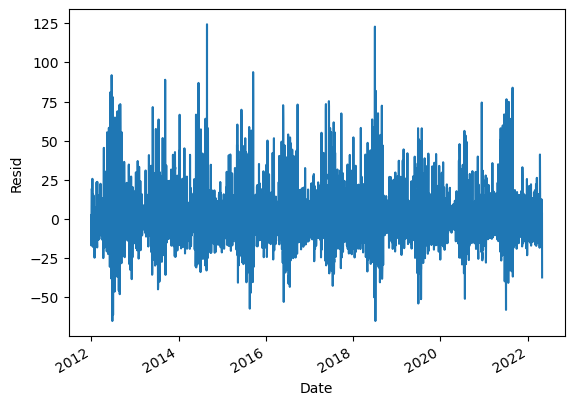

In [398]:
result.resid.plot()
plt.savefig('resid.png', transparent=True)
plt.ylabel('Resid')
# Display the plot
plt.show()

#### Significant deviations (either positive or negative) from zero in the residuals indicate anomalies.

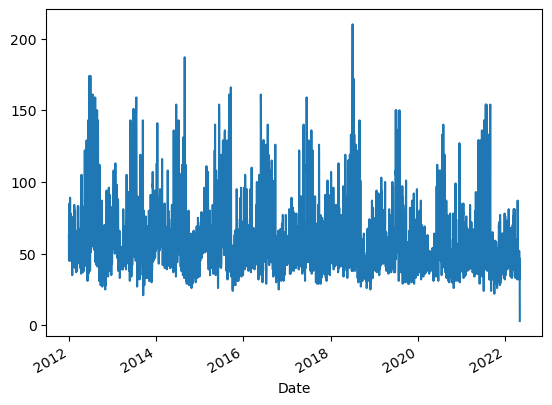

In [399]:
result.observed.plot()
plt.savefig('observed.png', transparent=True)

# Display the plot
plt.show()

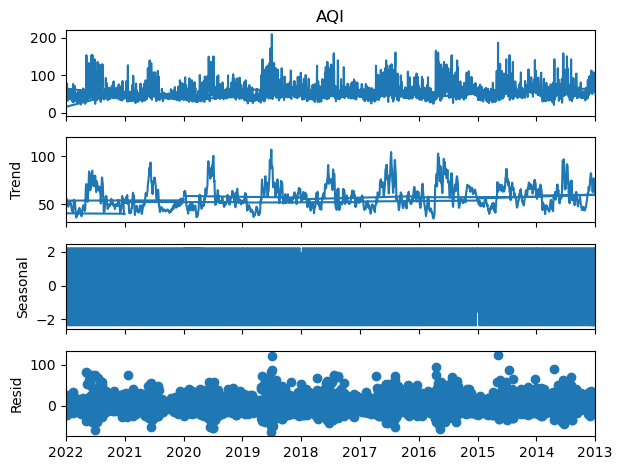

In [400]:
result.plot()
plt.savefig('all.png', transparent=True)

# Display the plot
plt.show()

## Facebook's Prophet

In [401]:
from prophet import Prophet

In [413]:
ny = ny_data_2012_2022[['Date', 'AQI']]
ny.columns = ['ds','y']
ny['ds'] = pd.to_datetime(ny['ds'])

ny.head()

ds   y
15819 2022-01-01  43
15820 2022-01-02  40
15821 2022-01-03  35
15822 2022-01-04  44
15823 2022-01-05  65

In [414]:
# Initialize and fit Prophet model & set the uncertainty interval to 95%
data_model_1 = Prophet(interval_width=0.95)
data_model_1.fit(ny)

18:29:08 - cmdstanpy - INFO - Chain [1] start processing
18:29:09 - cmdstanpy - INFO - Chain [1] done processing


#### Setting uncertainty interval to 95% allows us to captures most of the uncertainty inherent in the data, providing a more realistic range for future observations.

In [415]:
# Generates future dates for forecasting 
future = data_model_1.make_future_dataframe(periods=12, freq='M')
future.tail()

ds
3781 2022-12-31
3782 2023-01-31
3783 2023-02-28
3784 2023-03-31
3785 2023-04-30

In [416]:
# Generate forecasts
data_model_1_data=data_model_0.predict(future)
data_model_1_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2012-01-01  57.751661   19.219299   97.127229
1 2012-01-02  61.430316   19.368480  102.267639
2 2012-01-03  63.004929   22.473150  105.004107
3 2012-01-04  63.470095   23.698277  104.808996
4 2012-01-05  63.108854   23.887604  103.679984

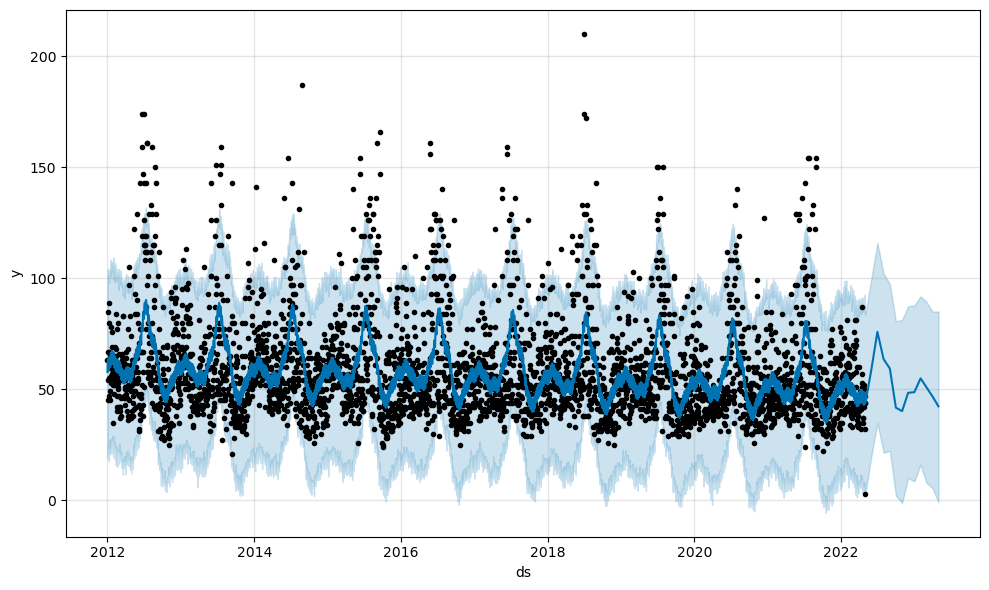

In [417]:
# Plot the forecasts with uncertainty intervals
data_model_0.plot(data_model_0_data, uncertainty=True)
plt.savefig('fb1.png', transparent=True)

# Display the plot
plt.show()

#### The trend line might show a general decrease in AQI over time, indicating improved air quality

18:29:15 - cmdstanpy - INFO - Chain [1] start processing
18:29:15 - cmdstanpy - INFO - Chain [1] done processing


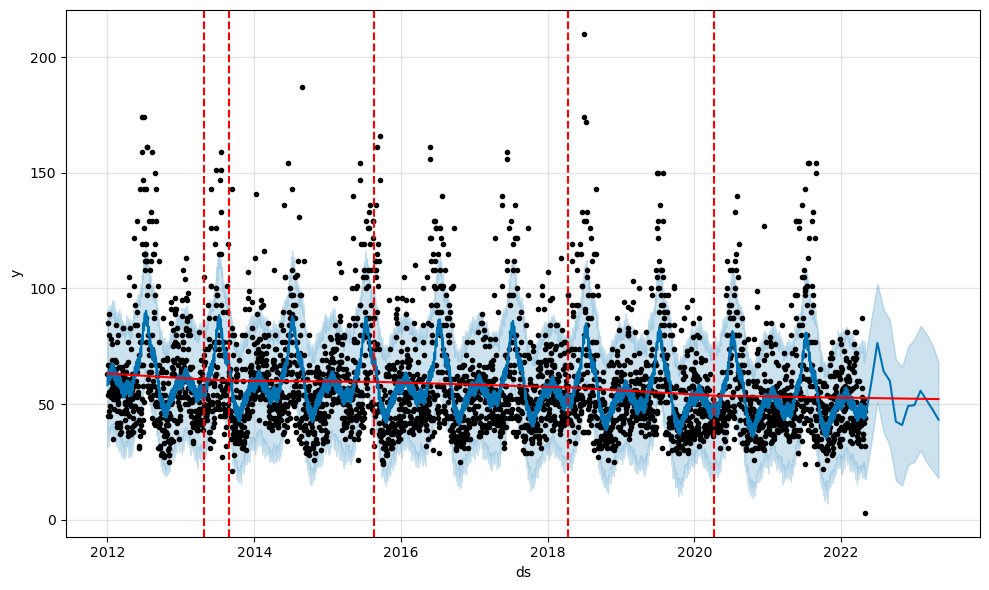

In [418]:
from prophet.plot import add_changepoints_to_plot
# Initialize and fit Prophet model with additional settings
data_model_1 = Prophet(daily_seasonality=True, n_changepoints=25, 
                  yearly_seasonality=True, 
                  changepoint_prior_scale=0.08
                   )
forecast = data_model_1.fit(ny).predict(future)
fig= data_model_1.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), data_model_1, forecast)

plt.savefig('fb.png', transparent=True)

# Display the plot
plt.show()

#### Adjusted the trend to indicate periods of significant change (red horizonatal lines) in the AQI trend. Points that fall outside the prediction interval likely indicate anomalies.

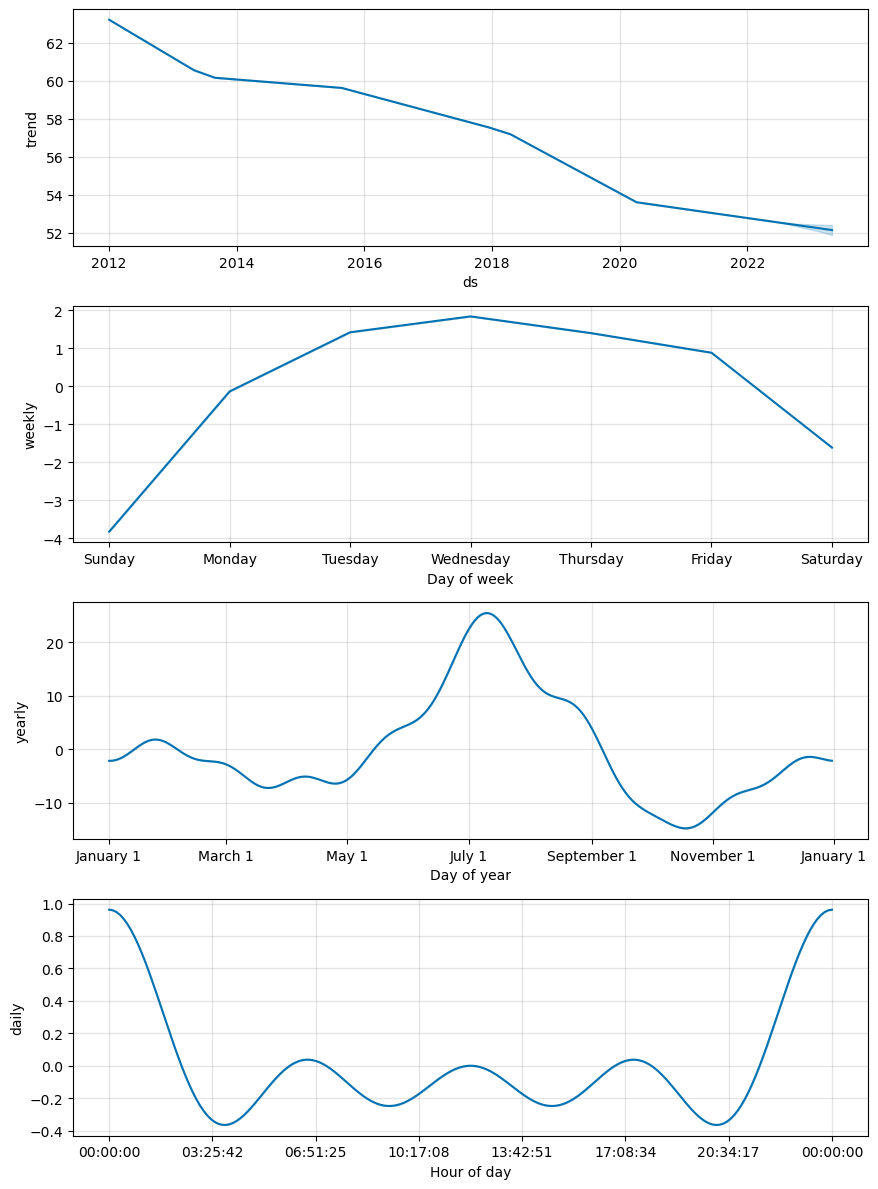

In [419]:
# Plot the components of the model
data_model_1.plot_components(forecast)
plt.savefig('comp.png', transparent=True)

# Display the plot
plt.show()

In [421]:
# Perform cross-validation for data_model_1
from prophet.diagnostics import cross_validation

data_1_cv = cross_validation(data_model_1, 
                             initial='2555 days',  # Adjusted initial window
                             period='30 days', 
                             horizon='365 days')

data_1_cv.head()

  0%|          | 0/29 [00:00<?, ?it/s]

18:29:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:22 - cmdstanpy - INFO - Chain [1] done processing
18:29:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:22 - cmdstanpy - INFO - Chain [1] done processing
18:29:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:22 - cmdstanpy - INFO - Chain [1] done processing
18:29:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:22 - cmdstanpy - INFO - Chain [1] done processing
18:29:23 - cmdstanpy - INFO - Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
18:29:23 - cmdstanpy - INFO - Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
18:29:23 - cmdstanpy - INFO - Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
18:29:24 - cmdstanpy - INFO - Chain [1] start processing
18:29:24 - cmdstanpy - INFO - Chain [1] done processing
18:29:24 - cmdstanpy - INFO - Chain [1] start processing
18:29:24 - cmdstanpy - INFO - Chain [1]

ds       yhat  yhat_lower  yhat_upper   y     cutoff
0 2019-01-13  55.126712   27.974207   82.954663  42 2019-01-12
1 2019-01-14  59.461940   33.290871   85.491191  52 2019-01-12
2 2019-01-15  61.602720   34.894121   86.299334  63 2019-01-12
3 2019-01-16  61.802582   32.998366   88.433174  67 2019-01-12
4 2019-01-17  62.010622   35.814815   90.780437  44 2019-01-12

In [422]:
# Calculate performance metrics for the cross-validation results
from prophet.diagnostics import performance_metrics
data_1_p = performance_metrics(data_1_cv)
data_1_p.head()

horizon         mse       rmse        mae      mape     mdape     smape  \
0 37 days  318.483795  17.846114  12.997259  0.240512  0.196512  0.228612   
1 38 days  316.805912  17.799042  12.962467  0.239578  0.194064  0.228007   
2 39 days  318.445805  17.845050  13.016958  0.240509  0.197050  0.228854   
3 40 days  323.578678  17.988293  13.088775  0.241629  0.197593  0.229742   
4 41 days  324.094283  18.002619  13.130391  0.243421  0.198670  0.230903   

   coverage  
0  0.893716  
1  0.895574  
2  0.894172  
3  0.892738  
4  0.891826

#### MAPE and SMAPE values around 0.24 and 0.22, respectively, suggest that the model's predictions, on average, deviate by around 24% and 22% from the actual values. This indicates moderate prediction accuracy. The coverage metric indicates the proportion of actual values that fall within the prediction intervals. A value around 0.89 (89%) suggests that most of the actual values are within the predicted range, indicating well-calibrated intervals.

## XGBoost

In [457]:
ny_data_2012_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3774 entries, 15819 to 1634792
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 3774 non-null   int64         
 1   CBSA Code                  3774 non-null   int64         
 2   Date                       3774 non-null   datetime64[ns]
 3   AQI                        3774 non-null   int64         
 4   Category                   3774 non-null   object        
 5   Defining Parameter         3774 non-null   object        
 6   Number of Sites Reporting  3774 non-null   int64         
 7   city_ascii                 3774 non-null   object        
 8   state_id                   3774 non-null   object        
 9   state_name                 3774 non-null   object        
 10  lat                        3774 non-null   float64       
 11  lng                        3774 non-null   float64       
 12  popu

In [484]:
ny = ny_data_2012_2022[['Date', 'AQI']]

In [463]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3774 entries, 15819 to 1634792
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3774 non-null   datetime64[ns]
 1   AQI     3774 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 88.5 KB


In [485]:
ny.set_index('Date', inplace = True)
ny.head()

AQI
Date           
2022-01-01   43
2022-01-02   40
2022-01-03   35
2022-01-04   44
2022-01-05   65

In [486]:
split_date = '2019-01-01'
ny_train = ny.loc[ny.index <= split_date].copy()
ny_test = ny.loc[ny.index > split_date].copy()

In [466]:
ny_train.head()

AQI
Date           
2019-01-01   45
2018-01-01   51
2018-01-02   57
2018-01-03  107
2018-01-04   52

In [471]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [473]:
X_train, y_train = create_features(ny_train, label='AQI')
X_test, y_test = create_features(ny_test, label='AQI')

In [474]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [475]:
ny_test['AQI_Prediction'] = reg.predict(X_test)
ny_all = pd.concat([ny_test, ny_train], sort=False)

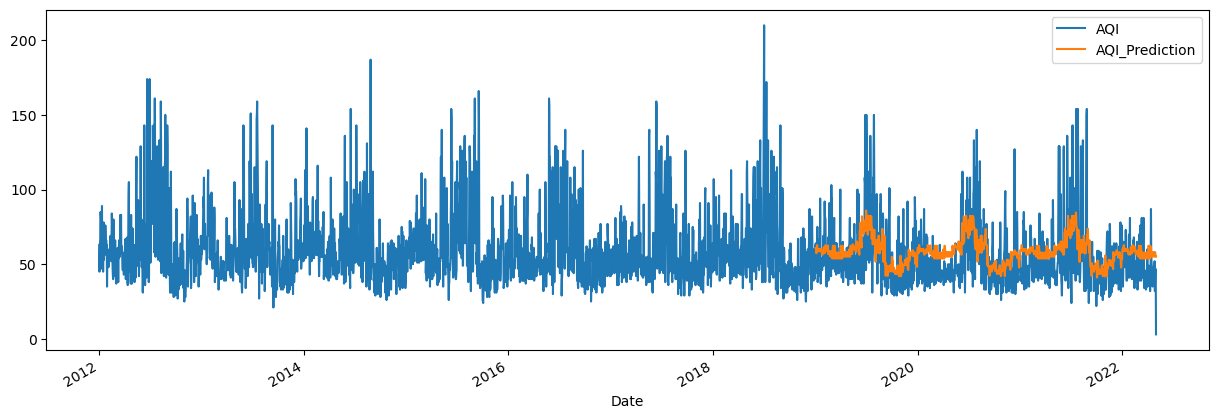

In [476]:
_ = ny_all[['AQI','AQI_Prediction']].plot(figsize=(15, 5))

In [479]:
mean_squared_error(y_true=ny_test['AQI'],
                   y_pred=ny_test['AQI_Prediction'])

379.25554550829895

In [480]:
mean_absolute_error(y_true=ny_test['AQI'],
                   y_pred=ny_test['AQI_Prediction'])

15.150709161632939

In [481]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [482]:
mean_absolute_percentage_error(y_true=ny_test['AQI'],
                   y_pred=ny_test['AQI_Prediction'])

31.394999535662944

### Based on the performance above, the Prophet model demonstrates better performancee compared to the XGBoost model with a stronger RMSE, MAE, and MAPE.